- Import
- Data Preprocessing
    - Data Cleaning
    - Removing Stopwords
    - Lemmatization
    - Named Entity Recognition (mit SPACY)
- Model
    - Vectorization (TF-IDF, WordCount)
    - Model
        - Logistic Regression
        
    
    


# Import


In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
#import sklearn.model_selection
#import sklearn.preprocessing as preproc
#from sklearn.feature_extraction import text

import spacy
!python -m spacy download en_core_web_sm
from spacy import displacy 
from collections import Counter



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score




!pip install wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /home/norbert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/norbert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/norbert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
df_fire = pd.read_csv('/home/norbert/AIDA/twitter-disaster/raw/disaster_tweets.csv', sep = ',' ) 


In [3]:
# Helperfunction


def info(dataframe):
  display(dataframe.head(5))
  display(dataframe.shape)
  display(dataframe.info())
  display(dataframe.describe())
  display(dataframe.dtypes)
  display(dataframe.isnull().sum())
  display(dataframe.sample(5))

In [4]:
#Analyse des Files

info(df_fire)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

,id,keyword,location,text,target
4702,6686,landslide,EGYPT,Italy: Three dead after landslide in the Itali...,1
1947,2799,curfew,Miami,In the beginning of summer my mom made my curf...,0
1829,2629,crashed,NaN,Pakistan says army helicopter has crashed in c...,1
4452,6335,hostages,THANJAVUR,2 hostages in Libya remain unharmed: Governmen...,1
5742,8196,riot,India,Stuart Broad Takes Eight Before Joe Root Runs ...,0


In [5]:
# Verteilung zwischen erfoglreichen Feueralarm und Fehlalarm
fire_alarm = df_fire['target'] == 1
print(f'fire alarm: {fire_alarm.sum()}.')

fire_fail = df_fire['target'] == 0
print(f'fire alarm failed: {fire_fail.sum()}.')

fire alarm: 3271.
fire alarm failed: 4342.


In [6]:
#detailierte Betrachtung der Texteinträge
df_fire.loc[:,'text'].values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

# Data Preprocessing

In [7]:
# Entfernung http
df_fire['text'] = df_fire['text'].str.replace('http\S+|www.\S+', '', case=False)
df_fire['text'].head(5)


0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [8]:
#Helper-Function

def clean_text(text):
  # get rid of all unwanted punctuation and digits
  
    text = text.replace("´", " ")
    text = text.replace("'", " ")
    text = text.replace(".", " ")
    text = text.replace("amp", " ")
    text = text.replace("#", " ")
    text = text.replace("like", " ")
    #text = text.replace("new", " ")
    #text = text.replace("news", " ")
    text = text.replace("get", " ") 
    
    digi_punct = "[^a-zA-Z]"
    text = re.sub(digi_punct, " ", text)

    digi_one_letter = r"\b[a-z]\b"
    text = re.sub(digi_one_letter, " ", text)

    digi_two_letter = r"\b[a-z][a-z]\b"
    text = re.sub(digi_two_letter, " ", text)
    
    #text = text.replace("\b[a-z]\b", " ")
    #text = text.replace("\b[a-z][a-z]\b", " ")

    #print('******')
    #print(text)
    text = " ".join(text.split())
    text = text.lower()
    print('******')
    print(text)  


    return text

In [9]:
#Cleaning

df_fire['text'] = df_fire['text'].apply(clean_text)
df_fire['text'].head()

******
our deeds are the reason this earthquake may allah forgive all
******
forest fire near la ronge sask canada
******
all residents asked shelter place are being notified officers no other evacuation shelter place orders are expected
******
people receive wildfires evacuation orders california
******
just got sent this photo from ruby alaska smoke from wildfires pours into school
******
rockyfire update california hwy closed both directions due lake county fire cafire wildfires
******
flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
******
i top the hill and i can see fire the woods
******
there emergency evacuation happening now the building across the street
******
i afraid that the tornado coming our area
******
three people died from the heat wave far
******
haha south t ting flooded hah wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
******
raining flooding florida t abay t days i lost count
******
f

******
parties and body bags her drinking and driving
******
limpar sweeping legs or putting people body bags
******
shoot shit till see body bags
******
your body will heal the bags under your eyes will away you happy you smile and really
******
womens handbags cross body geometric pattern satchel totes shoulder bags white rt gasparc
******
women messenger bags clutch bag handbag cross body shoulder bags bag ladies designer handbags high qualit
******
womens handbags cross body geometric pattern satchel totes shoulder bags white
******
status last seen buying body bags
******
asymbina tithenai i ered only liking cross body bags i really ella vickers bags machine washable
******
zicac vintage leather briefcase messenger satchel tote cross body handbags for womens
******
fairfax investigating firefighter over facebook post saying police should put body bags the washington post
******
mens cross body canvas waist packs solid letter print sports zipper bags coffee
******
listen this hit s

******
robdelaney catastrophe anything but i literally have been unable stop ejaculating
******
appleofficlal migrating from iphoto photo catastrophe i have wasted days trying this work hrsto complete
******
cultivating joy in the face of catastrophe and suffering pjnet tcot ccot
******
borrowers concerned possible interest rate rise this could catastrophe
******
uriminzok the coming catastrophe the destruction the puppet republic half naemolgo continue firmly support yiraneuni and against
******
failure misfortunebut regret catastrophe
******
deb that catastrophe man opens school another athlete not teacher principle not fulfilling any inside clerical duties
******
iphone twist ultimate preparedness library prepare yourself for any catastrophe ov
******
gemmahentsch megynkelly dloesch i can not envision any catastrophe that would prevent woman placing her child for adoption
******
peterjukes but there are good grounds believe that political military catastrophe was crime planned and c

******
party for bestival crash victim michael molloy what would have been his
******
cleared crash hamilton i south mm
******
deliver value a cash source crash course course
******
the next financial crash the writing the wall don say you weren warned
******
boy crash
******
make man pikin crash
******
incident crash pascoe vale south outbound tullamarine fwy citylink near moreland rd vehicles off emergency lane no delays
******
i let another love crash and burn
******
if you sit and rant snapchat your apparent fans when you have about followers i hope your train crash xoxo
******
crash and burn
******
cpanel crash course course
******
destinythegame bungie playstation getting kicked out that crash one the worst experiences i had playing video games
******
chelsdelong kendra leigh i crash
******
please keep josh the salyers blair hall families jenna friends your prayers she was taken far too soon rip
******
one night and gonna come and crash the party weren invited but feelin
******
f

but seriously i will electrocute half uk army i can touch bangtan not play games when comes bts
******
photo weallheartonedirection i wouldn let david electrocute himself i the asshole
******
i would electrocute everyone who uses the word fair connection with income tax policies william f buckley jr
******
photo weallheartonedirection i wouldn let david electrocute himself i the asshole
******
foxnews he still has his beard has been visited any while prison if keeps that hideous beard electrocute him uglypeople
******
but the sea would electrocute all
******
torro loco we can hear the conversation now sorry senator thought you said electrocute million etc
******
the links to watch the show better work or i might electrocute someone
******
when i was cooking earlier i got electrocuted some crucial now i psychic lol
******
pakistan news pakpattan city news man electrocuted from our correspondent pakpattan a man was electrocuted
******
hey bitch blow stick your dick some water then outlet

******
alert sandy hook elementary school evacuated after bomb threat
******
trafford centre film fans angry after odeon cinema evacuated following false fire alarm
******
evacuation orders lifted for roosevelt highway fire koin news
******
our thoughts are with these local residents time for some heavy rain
******
trafford centre film fans angry after odeon cinema evacuated following false fire alarm twi manchesterlite
******
passengers evacuated safely after green line train derails
******
hotel evacuated after fire shore drive norfolk
******
film doctor must leave immediately the core unstable the whole building told evacuated take the research we need
******
evacuation order lifted for town roosevelt washington times
******
rocky fire
******
ahrar al sham in our negotiations with iran over al zabadani they wanted all sunnis evacuated out al zabadani
******
entire town roosevelt wash evacuated because wildfire
******
katunews sr remains closed brush fire burns acres liveonk
******
g

former township fire truck being used philippines langley times philippines
******
former township fire truck being used philippines township langley assistant fire chief pat walker spen
******
our garbage truck really caught fire lmfao
******
kapokekito northgate the taco truck that fire
******
it never good sign when you pull work there five ambulances fire truck the bay wompppp least friday
******
fire truck and ambulance k phase hope everyone okay prayforsaipan
******
sigalert north southbound closed btwn fwy and irvine blvd due truck fire chp detouring traffic
******
eeenice true because the truck that caught fire
******
justinejayyy ohgod xd i didn mean p but you have that fire truck the back you make for you good xd
******
came across this fire video not mine enjoy babes way saying while the fire truck fireman
******
n past the l lane reopened all other lanes are closed all lanes are open the s trash truck fire cleanup knx
******
sigalert north southbound closed btwn fwy and irv

******
bad news for us china russia bolstering military cooperation asia sputnik international via sputnikint
******
study wider variety therapies could help vets troops with ptsd via militarydotcom
******
the mofo dc will leave our military unarmed gunned down terrorist lot worseits not their sorry asses
******
stu dorret mudslide rubber tyre cake may have saved you gbbo
******
it looks mudslide and gbbo back with belter
******
sterling scott the red carpet fundraiser for oso mudslide
******
stu put beetroot his cake and even lost mudslide
******
pete knox gemmasterful i think the mudslide cake lady will and the hipster will unfortunately stay
******
hope dorett mudslide cake wins gbbo
******
it looks mudslide it chewing rubber gbbo
******
the year old smug face when dorret brings out her mudslide black forest gateau priceless gbbo
******
marc holl nennicook aitchkaycee vixstuart benjbeckwith it not pretty disaster gbbo mudslide
******
looks mudslide and tastes rubber how i love the b

a mad catastrophe the outbreak world war i and the collapse the
******
families sue over legionnaires more than families affected the fatal outbreak legionnaires disea
******
wow the name legionnairesdisease comes from outbreak pneumonia the americanlegion convention philly died from
******
legionnaires disease what being done stop deadly outbreak
******
families sue over legionnaires more than families affected the fatal outbreak legionnaires disea
******
families sue over legionnaires more than families affected the fatal outbreak legionnaires disea
******
families sue over legionnaires more than families affected the fatal outbreak legionnaires disease edinburgh are
******
families sue over legionnaires more than families affected the fatal outbreak legionnaires disea
******
families sue over legionnaires more than families affected the fatal outbreak legionnaires disea
******
families sue over legionnaires more than families affected the fatal outbreak legionnaires disea
******
fam

month old baby girl was rescued coastguard after she floated half a mile out sea socialnews
******
but now skyrim awaits rescued again
******
rescued med migrants arrive sicily
******
the finnish hip hop pioneer paleface will rescued from drifting raft and brought into the container later enkelbiljett menolippu
******
bovines rescued smugglers nabbed
******
funds needed for rescued then abandoned cocker spaniels
******
i youtube video romanatwoodvlogs rescued sick kittens
******
news britons rescued amid himalaya floods
******
a brave little dog rescued from the river his recovery will inspi via youtube
******
homeless man traveling across usa with stray dogs he rescued gets a helping hand from strangers via reshareworthy
******
brittanypetko breaking news tonight kids were rescued from play room after week with food water parents sex life haha
******
you can only rescued from where you actually are and not from where you pretend you are giorgio hiatt
******
we rescued dog least years 

greenlacey godslove thanku sister for rt new video the coming apocalyptic us earthquake tsunami
******
all this energy
******
eric tsunami worry about yourself
******
it alil twister tha end i was nah
******
gail and russell saw lots hail their dalroy home they have video twister mile from their home yyc
******
want twister tickets and a chance at a vip experience to see shania click here
******
just stop fucking saying whole nother it just sounds fucking stupid you fucking mean whole other not fucking tongue twister
******
if landslide tumbles down todayi your side and twister sweeps all away you re on your own bitch runs into distance
******
love the twister thetwister and maddie and tae oktxduo
******
brain twister homefolks are opinionated over against proposal modernized canada omw
******
crazy mom threw teen daughter nude twister sex party according to her friend more pics
******
the sharper image viper hardside twister black
******
twister was fun
******
brain twister let drop t

feel i got control anything that goes life the minute whirlwind drained
******
richard returns after whirlwind few days mlb
******
set new record states days i don even know where i when i wake anymore what whirlwind loving every minute though
******
reap the whirlwind
******
theemobrago back doing another jitsu making hexagon the ground you laid there palms whirlwind i yelled air began
******
ckosova read whirlwind about this subject amongst others the bomb saved millions lives yes that true
******
in edfringe we highly recommend m nf l titania summerhallery a whirlwind reimagining shakespeare midsummer
******
the whirlwind scourge europe rt whedonesque or you could just watch the fanged four
******
whirlwind weekend starts hours cantwaittoplayinminneapolis
******
this week has been whirlwind but this exactly what imagined the nyc version career
******
my girl got a girlfriend chevy blue like whirlwind
******
picthis and i off thank you much toronto it has been such whirlwind amazingn

0    our deeds are the reason this earthquake may a...
1                forest fire near la ronge sask canada
2    all residents asked shelter place are being no...
3    people receive wildfires evacuation orders cal...
4    just got sent this photo from ruby alaska smok...
Name: text, dtype: object

In [10]:
#Entfernen von Duplikaten
df_fire.drop_duplicates(subset=['text'], inplace=True)


In [11]:
#Entfernung von stopwords

my_stopwords = stopwords.words("english")
df_fire["text_wo_stopwords"] = df_fire["text"].apply(
    lambda text: " ".join([word for word in text.split() if word not in my_stopwords]))
df_fire.head()

,id,keyword,location,text,target,text_wo_stopwords
0,1,NaN,NaN,our deeds are the reason this earthquake may a...,1,deeds reason earthquake may allah forgive
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked shelter place are being no...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,just got sent this photo from ruby alaska smok...,1,got sent photo ruby alaska smoke wildfires pou...


In [12]:
#Lemmatizer

lemmatizer = WordNetLemmatizer()
df_fire['text_clean_lem']= df_fire['text_wo_stopwords'].apply(lambda text_wo_stopwords: " ".join([lemmatizer.lemmatize(word) for word in text_wo_stopwords.split()]))
df_fire.head()

,id,keyword,location,text,target,text_wo_stopwords,text_clean_lem
0,1,NaN,NaN,our deeds are the reason this earthquake may a...,1,deeds reason earthquake may allah forgive,deed reason earthquake may allah forgive
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked shelter place are being no...,1,residents asked shelter place notified officer...,resident asked shelter place notified officer ...
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...
4,7,NaN,NaN,just got sent this photo from ruby alaska smok...,1,got sent photo ruby alaska smoke wildfires pou...,got sent photo ruby alaska smoke wildfire pour...


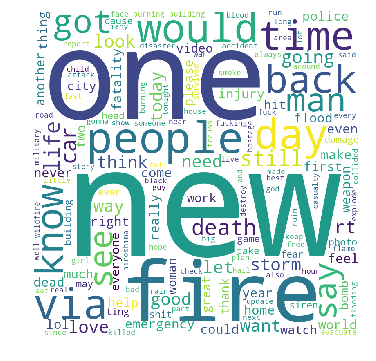

In [13]:
# Erstellung einer WordCloud

!pip install wordcloud
from wordcloud import WordCloud

wc = WordCloud(width=800, height=800, 
               background_color="white", 
               stopwords=[''],
               min_font_size=14
               )
wordcloud = wc.generate(" ".join(df_fire["text_clean_lem"]))

plt.figure(figsize=(6, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [14]:
special_word = df_fire['text_clean_lem'].str.contains('got').sum()
print(special_word)

141


In [15]:
df_fire.loc[df_fire['text_clean_lem'].str.contains('got'),'text_clean_lem']


4       got sent photo ruby alaska smoke wildfire pour...
67      kid cuz got bicycle accident split testicle im...
99      car even week got fucking car accident mf fuck...
241     fun filled happy hour simmons bar camden hands...
313     gonna beat armageddon hsu hao got flawless fir...
352     seeing army whitewalkers first thing slightly ...
441                               kill got court day earl
539                             got video rapper got song
562         check item got phantasmal cummerbund warcraft
615     darrellissa great iran deal cover bioterrorism...
618     creation ai climate change bioterrorism mass a...
659                                yo got bar even rapper
684              bowl got thinking damn blazing damn long
760                codythompson blew motor went flame got
789     todd calfee mattburgener wanted see info bligh...
872     man somebody gotta stop sbee dude fuckin funny...
893                   gotta try let many bloody thing smh
922           

In [16]:
special_word1 = df_fire['text_clean_lem'].str.contains('new').sum()
print(special_word1)

506


In [17]:
df_fire.loc[df_fire['text_clean_lem'].str.contains('new'),'text_clean_lem']


33      africanbaze breaking news nigeria flag set abl...
36      phdsquares mufc built much hype around new acq...
63      navista steve fire something else california t...
76                               accident knew gon happen
136     expert france begin examining airplane debris ...
175     leading emergency service bos welcome new ambu...
179       new nanotech device able tar destroy blood clot
182     news twelve feared killed pakistani air ambula...
203     twelve feared killed pakistani air ambulance h...
236     tomcatarts annihilated legion survivor imperfe...
288     rt zonewolf youtube video minecraft night luck...
314     enews ben affleck know wife kid girl help love...
384     another fake hate crime lesbian burn house els...
385     los angeles time arson suspect linked fire cau...
395     kisii police kisii hunt student failed arson p...
430     arsonist blamed blaze plastic recycling busine...
437     arsonist set nyc arian restaurant fire police ...
451     scare 

# Preprocessing with Spacy 

In [18]:
nlp = spacy.load('en_core_web_sm')
df_fire['text_clean_lem_spac'] = df_fire['text'].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)])).apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))

In [19]:
type(df_fire['text_clean_lem_spac'])

pandas.core.series.Series

In [20]:
#Text preprocessing with Spacy 

nlp = spacy.load('en_core_web_sm')
text1 = str(df_fire['text_clean_lem_spac'])
doc = nlp(text1)
type(doc)

spacy.tokens.doc.Doc

In [21]:
#Text preprocessing with Spacy 

nlp = spacy.load('en_core_web_sm')





In [22]:
# Spacy token

df = pd.DataFrame()

for i, token in enumerate(doc):
    df.loc[i, 'text'] = token.text
    df.loc[i, 'pos'] = token.pos_
    df.loc[i, 'tag'] = token.tag_
df.head(5)

,text,pos,tag
0,0,NUM,CD
1,,SPACE,_SP
2,-PRON-,PUNCT,HYPH
3,deed,NOUN,NN
4,be,AUX,VB


In [23]:
# Zergliederung des Textes in einzelne Wörter

df = pd.DataFrame()
for i,token in enumerate(doc):
    df.loc[i,'text'] = token.text
    
print(df.head(15))    

                  text
0                    0
1                     
2               -PRON-
3                 deed
4                   be
5                  the
6               reason
7                 this
8           earthquake
9                  may
10                 ...
11                  \n
12                   1
13                    
14              forest


In [24]:
# Klassifizierung der Token I

for word in doc[:1000]:
    print(f'{word.text:{15}} {word.pos_:{10}} {word.tag_:{10}} {spacy.explain(word.tag_)}')

0               NUM        CD         cardinal number
                SPACE      _SP        None
-PRON-          PUNCT      HYPH       punctuation mark, hyphen
deed            NOUN       NN         noun, singular or mass
be              AUX        VB         verb, base form
the             DET        DT         determiner
reason          NOUN       NN         noun, singular or mass
this            DET        DT         determiner
earthquake      NOUN       NN         noun, singular or mass
may             VERB       MD         verb, modal auxiliary
...             PUNCT      NFP        superfluous punctuation

               SPACE      _SP        None
1               NUM        CD         cardinal number
                   SPACE      _SP        None
forest          NOUN       NN         noun, singular or mass
fire            NOUN       NN         noun, singular or mass
near            SCONJ      IN         conjunction, subordinating or preposition
la              PROPN      NNP        

In [25]:
# Visisualization of named entities

spacy.displacy.render(doc, style='ent',jupyter=True)

In [26]:
# Visisualization of named entities

spacy.displacy.render(doc, style='dep',jupyter=True,options = {'compact':60})

In [27]:
word_freq = Counter([word.pos_ for word in doc])
common_words = word_freq.most_common(15)
print (common_words)

[('SPACE', 121), ('NOUN', 114), ('PROPN', 96), ('NUM', 65), ('PUNCT', 45), ('VERB', 41), ('DET', 27), ('ADV', 22), ('ADJ', 19), ('PRON', 17), ('AUX', 11), ('ADP', 10), ('CCONJ', 9), ('SCONJ', 5), ('INTJ', 1)]


# Logistic Regression
    - Lemmatizer, Stopwords

In [28]:
# Train Test Split mit der bereinigten Spalte
X=df_fire['text_clean_lem']
y=df_fire['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(5476,)

(1369,)

(5476,)

(1369,)

In [29]:
# logistic regression

pipe = make_pipeline(CountVectorizer(), LogisticRegression())
pipe.fit(X_train, y_train)



/home/norbert/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [30]:
# prediction auf basis der x_Testdaten
prediction  = pipe.predict(X_test)
print(classification_report(y_test, prediction)) 

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       809
           1       0.78      0.67      0.72       560

   micro avg       0.79      0.79      0.79      1369
   macro avg       0.79      0.77      0.77      1369
weighted avg       0.79      0.79      0.78      1369



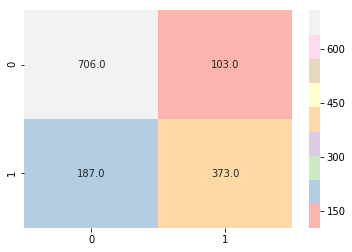

In [31]:
# Heatmap
sns.heatmap(confusion_matrix(y_test, prediction), cmap = 'Pastel1', annot=True, fmt=".1f");

In [32]:
nlp = spacy.load('en_core_web_sm')
X1=df_fire['text_clean_lem_spac']
y1=df_fire['target']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
display(X1_train.shape) 
display(X1_test.shape)
display(y1_train.shape)
display(y1_test.shape)

(5476,)

(1369,)

(5476,)

(1369,)

# Logistic Regression
- Spacy

In [33]:
# logistic regression with spacy corrected text

pipe = make_pipeline(CountVectorizer(), LogisticRegression())
pipe.fit(X1_train, y1_train)



Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [37]:
# prediction auf basis der X1 Spacy_Testdaten
prediction1  = pipe.predict(X1_test)
print(classification_report(y1_test, prediction1)) 

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       809
           1       0.79      0.66      0.72       560

   micro avg       0.79      0.79      0.79      1369
   macro avg       0.79      0.77      0.77      1369
weighted avg       0.79      0.79      0.78      1369



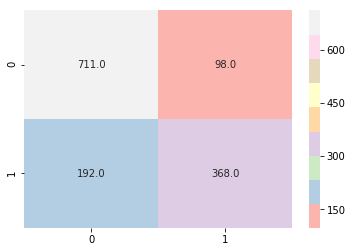

In [35]:
# Heatmap
sns.heatmap(confusion_matrix(y1_test, prediction), cmap = 'Pastel1', annot=True, fmt=".1f");

In [36]:
df_fire.to_csv('/home/norbert/AIDA/twitter-disaster/raw/twitter_disaster_preprocessing.csv',header=False)